# Machine Listening (Fall 2020)
# Lab3: Music Analysis

# lab3 - 1 : Onset Detection

get authorization to read audio files in google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


read audio file

In [13]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np


#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/T08-violin-8k.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/temp_beat.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/T39-piano-8k.wav'

audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/T39-piano-8k.wav'

audio, sr = librosa.load(audio_path, sr=None)
print('sample rate of this audio file :', sr, 'Hz')
ipd.Audio(audio, rate=sr, autoplay=False) # play audio

sample rate of this audio file : 8000 Hz


Time-domain Onset Detection

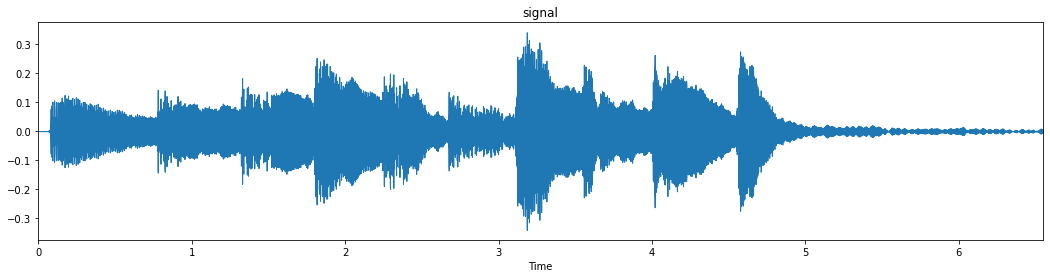

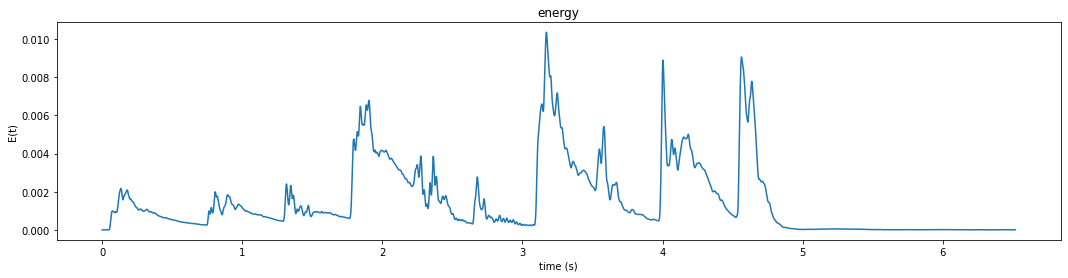

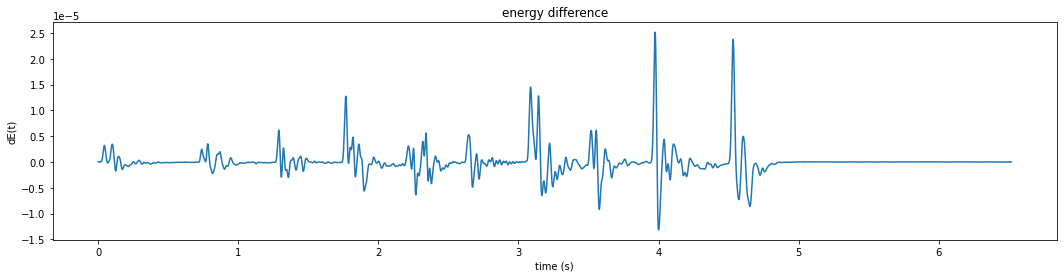

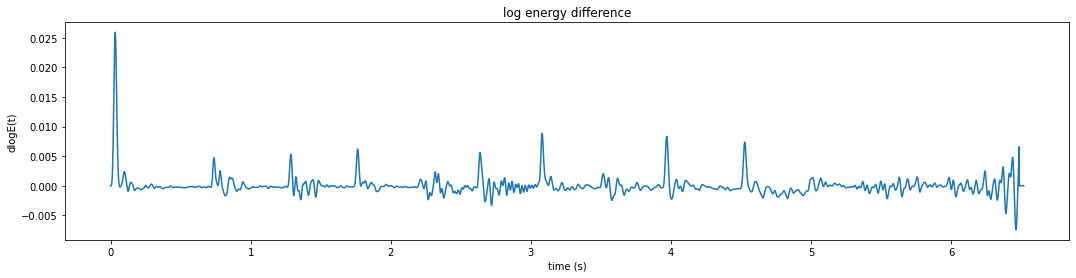

In [3]:
import matplotlib.pyplot as plt

# smoothing window
M = 256
window = np.hamming(M)


# compute E(n)
e = np.zeros(len(audio)-M)

for i in range(0,len(audio)-M):
  e[i] = np.sum(np.square(np.multiply(audio[i:i+M],window)))/M


# compute dE(n)
de = np.zeros(len(audio)-M)

diffe = np.diff(e) # first-order difference

for i in range(0,len(diffe)-M):
  de[i] = np.sum(np.multiply(diffe[i:i+M],window))/M


  
# compute log(dE)
dloge = np.zeros(len(audio)-M)

diffloge = np.diff(np.log(e + 0.0000001))

for i in range(0,len(diffloge)-M):
  dloge[i] = np.sum(np.multiply(diffloge[i:i+M],window))/M


time_index = np.arange(len(audio)-M)/sr

plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.title('signal')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(time_index,e)
plt.title('energy')
plt.xlabel('time (s)')
plt.ylabel('E(t)')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(time_index,de)
plt.title('energy difference')
plt.xlabel('time (s)')
plt.ylabel('dE(t)')
plt.show()


plt.figure(figsize=(18, 4))
plt.plot(time_index,dloge)
plt.title('log energy difference')
plt.xlabel('time (s)')
plt.ylabel('dlogE(t)')
plt.show()

Frequency-domain Onset Detection

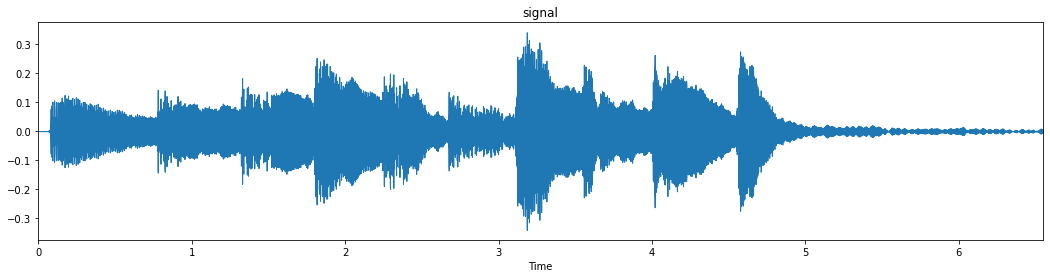

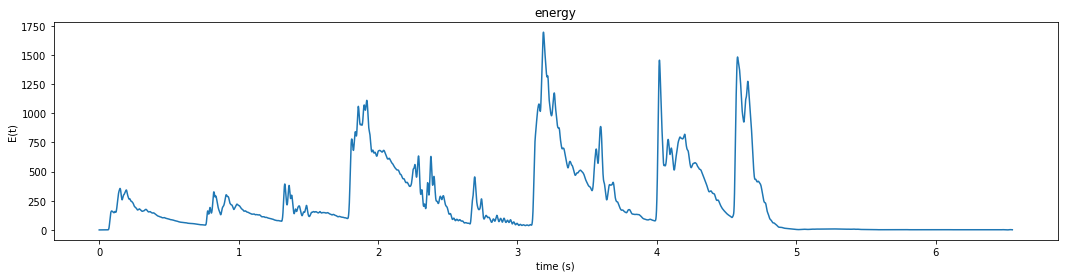

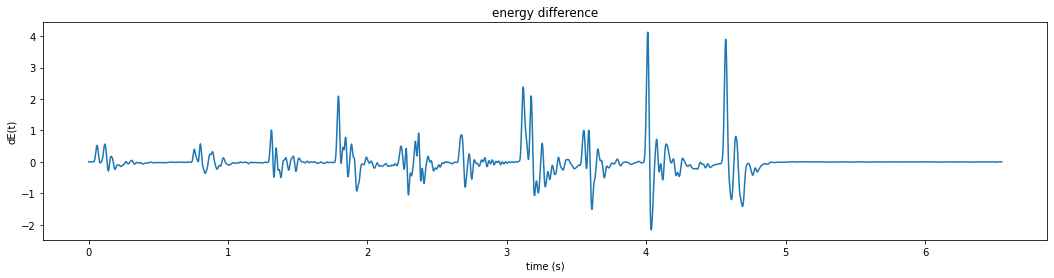

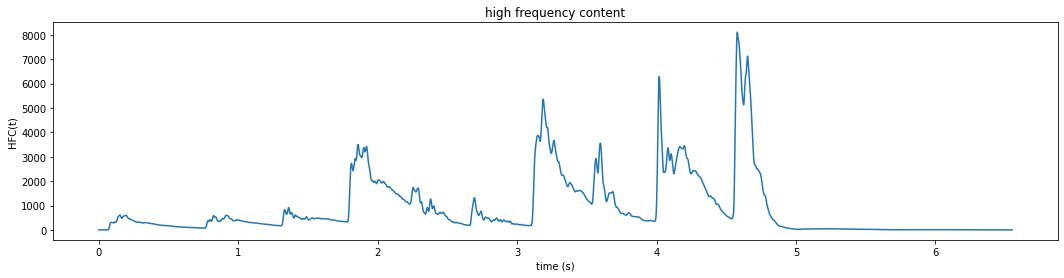

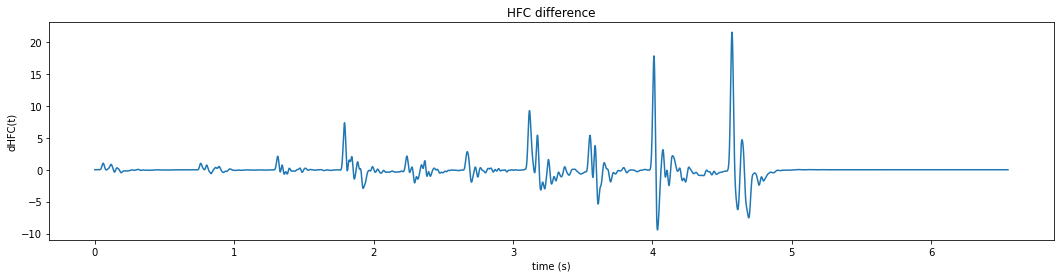

In [4]:
# first compute spectrogram

M = 256
win = np.hamming(M)
zpf = 5
nfft = M*zpf

spec = librosa.core.stft(audio, n_fft=nfft, hop_length=1, win_length=M, window=win, center=True)
nframe = np.shape(spec)[1]

# energy
e = np.sum(np.power(np.abs(spec),2),axis=0)

# energy difference
diffe = np.diff(e) # first-order difference
de = np.zeros(len(diffe)-M)
for i in range(0,len(diffe)-M):
  de[i] = np.sum(np.multiply(diffe[i:i+M],window))/M

  
# high frequency content (HFC)
hfc = []

fi = np.linspace(0, sr/2, num=np.shape(spec)[0])

for i in range(0,nframe):
  X = spec[:,i]
  hfc.append(np.sum(np.multiply(fi,np.power(np.abs(X),2)),axis=0)/(M/2+1))


# HFC difference
diffhfc = np.diff(hfc) # first-order difference
dhfc = np.zeros(len(diffhfc)-M)
for i in range(0,len(diffhfc)-M):
  dhfc[i] = np.sum(np.multiply(diffhfc[i:i+M],window))/M



ti = np.linspace(0, len(audio)/sr, num=np.shape(spec)[1])
ti_de = np.linspace(0, len(audio)/sr, num=len(de))
ti_hfc = np.linspace(0, len(audio)/sr, num=len(hfc))
ti_dhfc = np.linspace(0, len(audio)/sr, num=len(dhfc))

plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.title('signal')
plt.show()



plt.figure(figsize=(18, 4))
plt.plot(ti,e)
plt.title('energy')
plt.xlabel('time (s)')
plt.ylabel('E(t)')
plt.show()


plt.figure(figsize=(18, 4))
plt.plot(ti_de,de)
plt.title('energy difference')
plt.xlabel('time (s)')
plt.ylabel('dE(t)')
plt.show()



plt.figure(figsize=(18, 4))
plt.plot(ti_hfc,hfc)
plt.title('high frequency content')
plt.xlabel('time (s)')
plt.ylabel('HFC(t)')
plt.show()


plt.figure(figsize=(18, 4))
plt.plot(ti_dhfc,dhfc)
plt.title('HFC difference')
plt.xlabel('time (s)')
plt.ylabel('dHFC(t)')
plt.show()


Phase-based Onset Detection

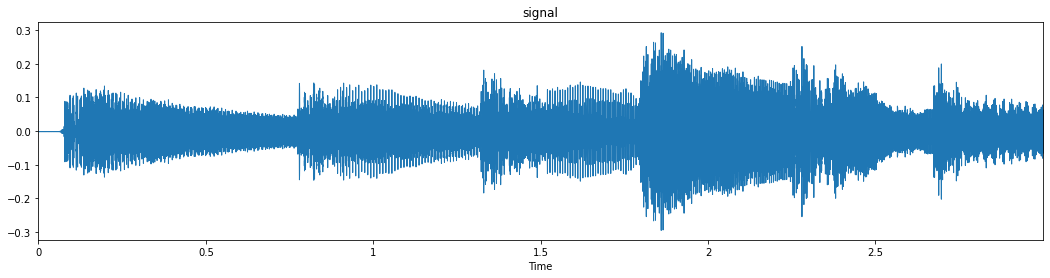

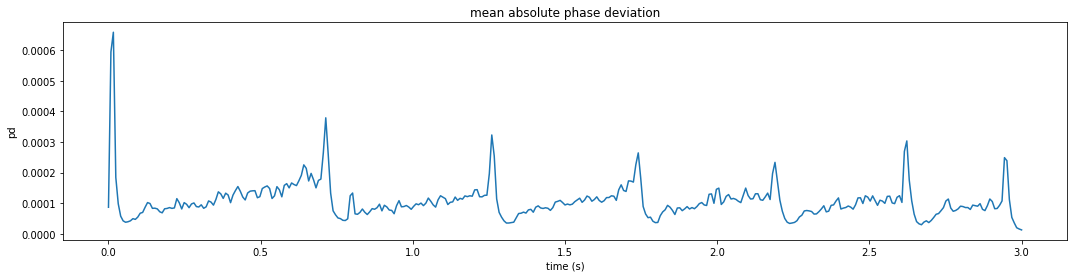

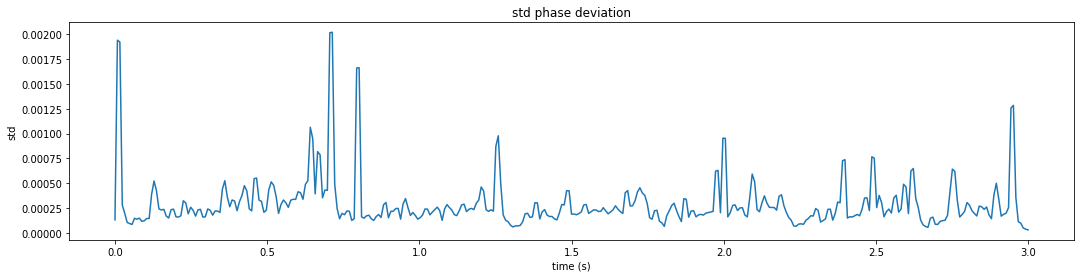

In [ ]:
import scipy.signal as signal

x = audio[0:int(sr*3)]
M = 1024
hopsize = int(M/16)
hopfac = int(M/hopsize)
Nfft = M

overlap = Nfft*(1-1/hopfac)
win = np.ones(Nfft)

# Rectangular window STFT analysis.
_,_,X = signal.stft(x,fs=sr, window=win,nperseg=M,noverlap = overlap)

# FFT bins
k = np.arange(Nfft/2 + 1)

ifr = np.zeros(np.shape(X))
T = np.zeros(np.shape(X)[1])

for i in range(0,np.shape(X)[1]):
  # one instance of the spectrum
  Xk = X[:,i]
  Xkplus1 = np.append(Xk[1:],0.000001)
  Xkminus1 = np.append(0.00001,Xk[0:-1])

  # frequency estimation (hop one trick)
  ifr[:,i] = np.multiply(sr,np.subtract(np.divide(k,Nfft),np.imag(np.multiply(1j/Nfft,np.divide(np.subtract(Xkplus1,Xkminus1),np.add(np.subtract(np.subtract(np.multiply(Xk,2),Xkplus1),Xkminus1),2*0.000001))))))
  # currnet time
  T[i] = i*((Nfft/hopfac)/sr)
  
  
dif = np.divide(np.diff(ifr),sr*2*np.pi)
pd = np.mean(np.abs(dif),axis=0)


# compute std of absolute phase deviation
stdev = np.zeros(len(T)-1)

for i in range(0,len(T)-1):
  stdev[i] = np.std(np.abs(dif[:,i]))

ti_pd = np.linspace(0, len(x)/sr, num=len(pd))
ti_stdev = np.linspace(0, len(x)/sr, num=len(stdev))

plt.figure(figsize=(18,4))
librosa.display.waveplot(x, sr)
plt.title('signal')
plt.show()


plt.figure(figsize=(18, 4))
plt.plot(ti_pd,pd)
plt.title('mean absolute phase deviation')
plt.xlabel('time (s)')
plt.ylabel('pd')
plt.show()


plt.figure(figsize=(18, 4))
plt.plot(ti_stdev,stdev)
plt.title('std phase deviation')
plt.xlabel('time (s)')
plt.ylabel('std')
plt.show()


# lab3 - 2 : Pitch Estimation

finding Spectral peaks

In [5]:
from scipy.signal import find_peaks

# first compute spectrogram
M = 1024
win = np.hamming(M)
zpf = 5
nfft = M*zpf

spec = librosa.core.stft(audio, n_fft=nfft, hop_length=int(M/2), win_length=M, window=win, center=True)
nframe = np.shape(spec)[1]

# find spectral peaks
binsize = sr/nfft
m = 10 # number of peaks to be found
peaks = np.zeros((m,nframe))
frqs = np.zeros((m,nframe))
fi = np.linspace(0, sr/2, num=np.shape(spec)[0])

for i in range(0,nframe):
  X = spec[:,i]
  Xdb = 20*np.log10(np.abs(X)+0.000001)
  if np.mean(Xdb) < -80:
    peaks[:,i] = zeros(m,1)
    frqs[:,i] = zeros(m,1)
  else:
    peak, _ = find_peaks(Xdb, distance=20)
    peak_values = Xdb[peak]
    # get top m peaks
    top_m = np.sort(peak[np.argpartition(peak_values,-m)[-m:]])
    peaks[:,i] = top_m/np.shape(spec)[0]*sr/2
    frqs[:,i] = Xdb[top_m]




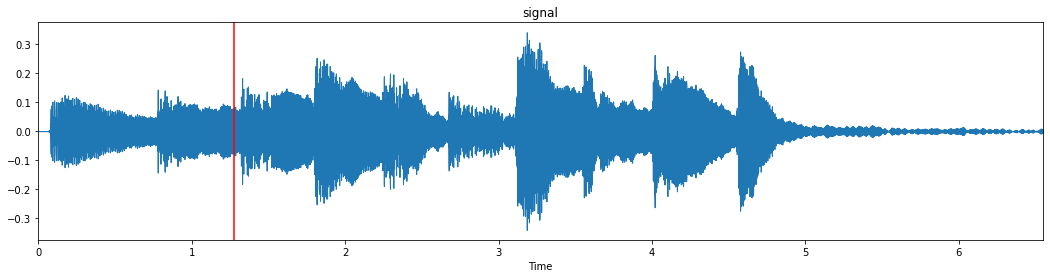

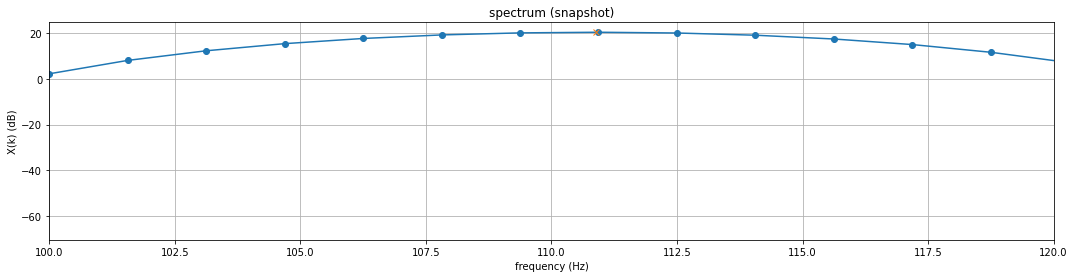

In [8]:
# plot t'th snapshot
t = 20


plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.title('signal')
plt.axvline(x=t/nframe*len(audio)/sr,color='r')
plt.show()

plt.figure(figsize=(18, 4))
plt.title('spectrum (snapshot)')
plt.xlabel('frequency (Hz)')
plt.ylabel('X(k) (dB)')
plt.plot(fi,20*np.log10(np.transpose(np.abs(spec[:,t]))+0.000001),'o-')
plt.plot(peaks[:,t], frqs[:,t], "x")
plt.xlim([100, 120])
plt.grid()
plt.show()

Pitch estimation using HPS(Harmonic Product Spectrum)

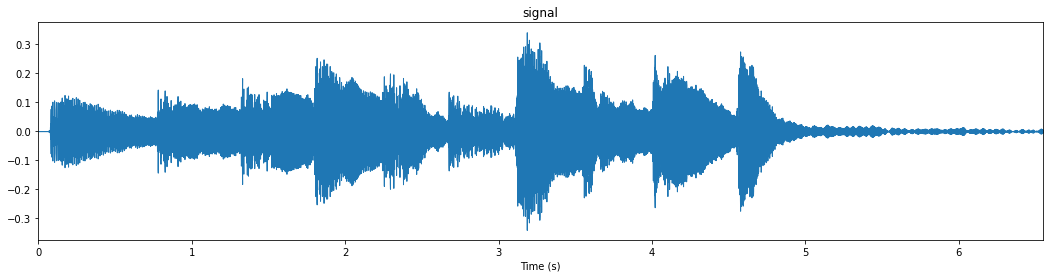

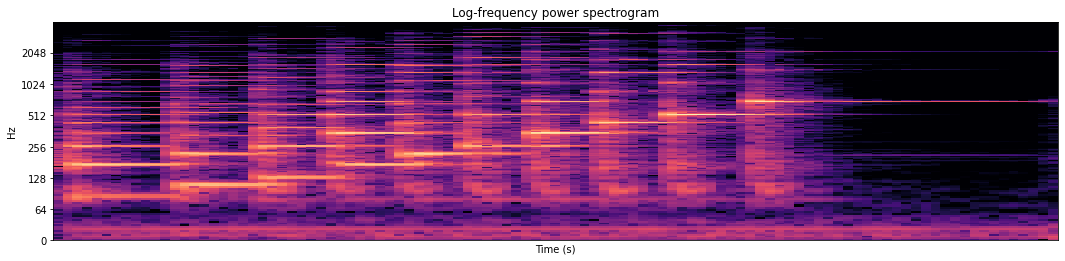

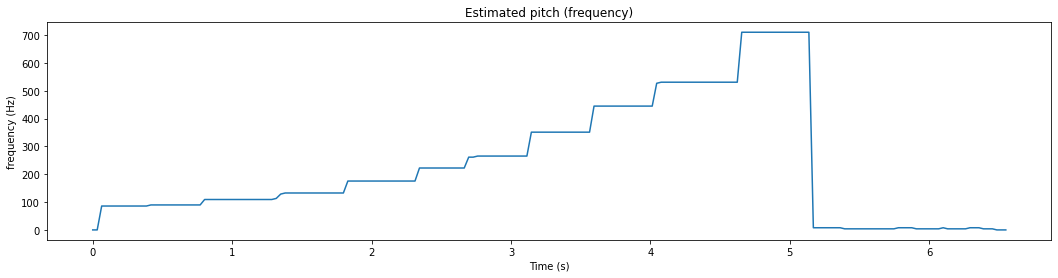

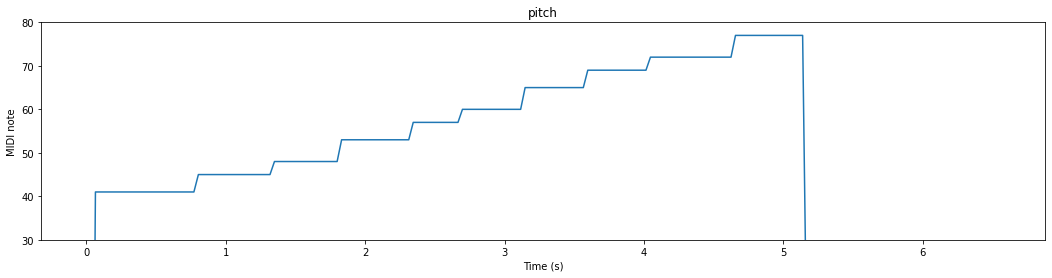

In [9]:
from scipy.signal import medfilt


# HPS(Harmonic Product Spectrum)
def hps(Xdb,ndeci):
  X_hps = -80*np.ones((len(Xdb),ndeci))
  for i in range(1,ndeci):
    X_ds = Xdb[0::i]
    nzeros = len(Xdb) - len(X_ds)
    pad = -80*np.ones(nzeros)
    X_hps[:,i] = np.append(X_ds, pad)
  return np.sum(X_hps,axis=1)


# compute spectrogram
M = 512
win = np.hamming(M);
zpf = 4;
nfft = M*zpf;

spec = librosa.core.stft(audio, n_fft=nfft, hop_length=int(M/2), win_length=M, window=win, center=True)
hpspec = np.zeros(np.shape(spec))
nframe = np.shape(spec)[1]
fi = np.linspace(0, sr/2, num=np.shape(spec)[0])
ti = np.linspace(0, len(audio)/sr, num=np.shape(spec)[1])

# estimate pitch
for i in range(0,nframe):
  hpspec[:,i] = hps(20*np.log10(np.abs(spec[:,i])),5)

# pick peak for f0
p_hps = []
for i in range(0,nframe):
  X = hpspec[:,i]  
  p_hps.append(np.argmax(X)/np.shape(spec)[0]*sr/2)
  
# smoothing using median filtering
p_sm = medfilt(p_hps,11)


# convert to MIDI note
m = np.round(12*np.log2(p_sm/440 + 0.0001)) + 69




plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.title('signal')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(18,4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr)
plt.title('Log-frequency power spectrogram')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(18, 4))
plt.title('Estimated pitch (frequency)')
plt.xlabel('Time (s)')
plt.ylabel('frequency (Hz)')
plt.plot(ti,p_sm)
plt.show()


plt.figure(figsize=(18, 4))
plt.title('pitch')
plt.xlabel('Time (s)')
plt.ylabel('MIDI note')
plt.ylim([30,80])
plt.plot(ti,m)
plt.show()


# lab3 - 3 : Key Estimation

load audio

In [17]:
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/prelude_cmaj_short_11k.wav'
audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/prelude_cmaj_short_11k.wav'


audio, sr = librosa.load(audio_path, sr=None)
print('sample rate of this audio file :', sr, 'Hz')
ipd.Audio(audio, rate=sr, autoplay=False) # play audio


sample rate of this audio file : 11025 Hz


plot chromagram

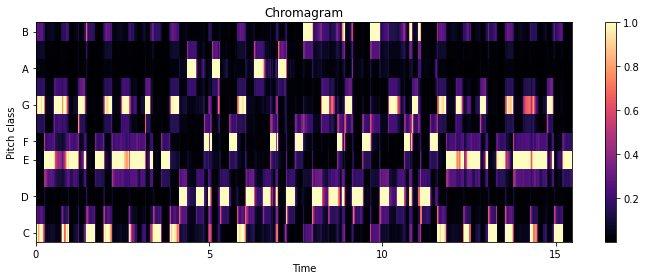

In [18]:

S = np.abs(librosa.stft(audio, n_fft=1024, hop_length=int(1024/4)))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()


Key estimation

estimated key : F


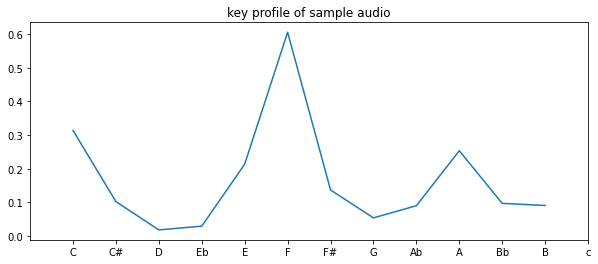

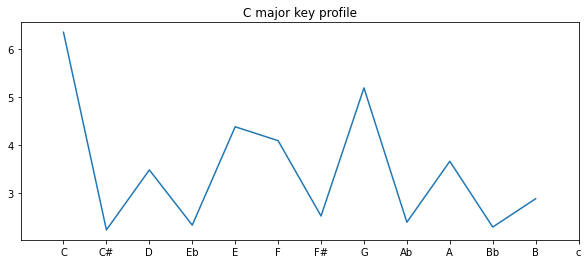

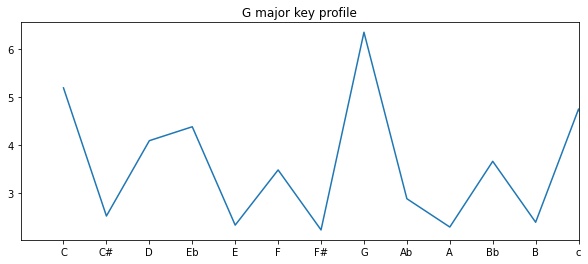

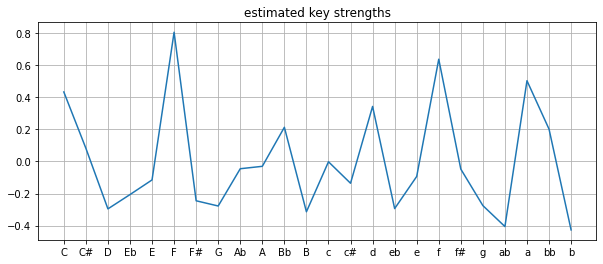

In [15]:
# compute chromagram average

ch_avg = np.mean(chroma,1)
# key profiles (from Krumhansl)
Cmaj_key_prof = [6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88]
Cmin_key_prof = [6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17]
maj_prof = [] # major key profile
min_prof = [] # minor key profile



for i in range(0,12): # for each key
  maj_prof.append(np.roll(Cmaj_key_prof,i))
  min_prof.append(np.roll(Cmin_key_prof,i))
  

key_prof = maj_prof + min_prof
key_prof = np.transpose(key_prof)


cor = []
for i in range(0,24):
  cor.append(np.corrcoef(ch_avg,key_prof[:,i])[0,1])



# display
key_label = ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B','c','c#','d','eb','e','f','f#','g','ab','a','bb','b']

# select maximum correlation profile
print('estimated key : ' + key_label[np.argmax(cor)])




plt.figure(figsize=(10, 4))
plt.plot(ch_avg)
plt.title('key profile of sample audio')
plt.xticks(np.linspace(0,23,num=24), key_label)
plt.xlim([-1,12])
plt.show()



# key profiles
plt.figure(figsize=(10, 4))
plt.plot(Cmaj_key_prof)
plt.title('C major key profile')
plt.xticks(np.linspace(0,23,num=24), key_label)
plt.xlim([-1,12])
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(key_prof[7,:])
plt.title('G major key profile')
plt.xticks(np.linspace(0,23,num=24), key_label)
plt.xlim([-1,12])
plt.show()


# estimated key
plt.figure(figsize=(10, 4))
plt.plot(cor)
plt.title('estimated key strengths')
plt.xticks(np.linspace(0,23,num=24), key_label)
plt.grid()
plt.show()


# lab3 - 4 : Chord Recognition

functions for chrd recognition using template matching

In [19]:

'''
Details given in the paper Automatic Chord Recognition from Audio Using Enhanced Pitch Class Profile - Kyogu Lee, CCRMA Stanford.
code by Orchisama Das, Stanford
https://github.com/orchidas
'''


from scipy.signal import hamming
from scipy.fftpack import fft
from __future__ import division
import os
import json


def nearestPow2(inp):
    power = np.ceil(np.log2(inp))
    return 2**power

"""Function to calculcate Harmonic Power Spectrum from DFT"""

def HPS(dft,M):
  hps_len = int(np.ceil(np.size(dft)/(2**M)))
  hps = np.ones(hps_len)
  for n in range(hps_len):
 		for m in range(M+1): 
 			hps[n] *= np.absolute(dft[(2**m)*n])
  return hps

"""Function to compute CQT using sparse matrix multiplication, Brown and Puckette 1992- fast"""	
def CQT_fast(x,fs,bins,fmin,fmax,M):
	threshold = 0.0054 #for Hamming window
	K = int(bins*np.ceil(np.log2(fmax/fmin)))
	Q = 1/(2**(1/bins)-1)
	nfft = np.int32(nearestPow2(np.ceil(Q*fs/fmin)))
	tempKernel = np.zeros(nfft, dtype = np.complex)
	specKernel = np.zeros(nfft, dtype = np.complex)
	sparKernel = []

	#create sparse Kernel 
	for k in range(K-1,-1,-1):
		fk = (2**(k/bins))*fmin
		N = np.int32(np.round((Q*fs)/fk))
		tempKernel[:N] = hamming(N)/N * np.exp(-2*np.pi*1j*Q*np.arange(N)/N)
		specKernel = fft(tempKernel)
		specKernel[np.where(np.abs(specKernel) <= threshold)] = 0
		if k == K-1:
			sparKernel = specKernel
		else:
			sparKernel = np.vstack((specKernel, sparKernel))
	
	sparKernel = np.transpose(np.conjugate(sparKernel))/nfft
	ft = fft(x,nfft)
	cqt = np.dot(ft, sparKernel)
	ft = fft(x,nfft*(2**M))
	#calculate harmonic power spectrum
	#harm_pow = HPS(ft,M)
	#cqt = np.dot(harm_pow, sparKernel)
	return cqt


"""Function to compute constant Q Transform, Judith Brown, 1991 - slow"""
def CQT_slow(x, fs, bins, fmin, fmax):
	
	K = int(bins*np.ceil(np.log2(fmax/fmin)))
	Q = 1/(2**(1/bins)-1)
	cqt = np.zeros(K, dtype = np.complex)

	for k in range(K):
		fk = (2**(k/bins))*fmin
		N = int(np.round(Q*fs/fk))
		arr = -2*np.pi*1j*Q*np.arange(N)/N 
		cqt[k] = np.dot(x[:N], np.transpose(hamming(N) * np.exp(arr)))/N 
	return cqt


"""Function to compute Pitch Class Profile from constant Q transform"""
def PCP(cqt,bins,M):
	CH = np.zeros(bins)
	for b in range(bins):
		CH[b] = np.sum(cqt[b + (np.arange(M)*bins)])
	return CH


def compute_chroma(x,fs):

	fmin = 96
	fmax = 5250
	bins = 12
	M = 3
	nOctave = np.int32(np.ceil(np.log2(fmax/fmin)))
	CH = np.zeros(bins)
	#Compute constant Q transform
	cqt_fast = CQT_fast(x,fs,bins,fmin,fmax,M)
	#get Pitch Class Profile
	CH = PCP(np.absolute(cqt_fast), bins, nOctave)
	return CH




"""read from JSON file to get chord templates"""
with open('/content/drive/My Drive/machine_listening_2020/lab/lab3/chord_templates.json', 'r') as fp:
    templates_json = json.load(fp)

chords = ['N','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','Gm','G#m','Am','A#m','Bm','Cm','C#m','Dm','D#m','Em','Fm','F#m']
templates = []

for chord in chords:
	if chord is 'N':
		continue
	templates.append(templates_json[chord])


load audio

In [20]:
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/Grand Piano - Fazioli - major A# middle.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/Grand Piano - Fazioli - major C# middle.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/Grand Piano - Fazioli - minor chords - F#m higher.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/Grand Piano - Fazioli - minor chords - G#m higher.wav'


audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab3/wav/Grand Piano - Fazioli - minor chords - G#m higher.wav'

s, fs = librosa.load(audio_path, sr=None)
ipd.Audio(s, rate=fs, autoplay=False) # play audio


chord recognition using template matching

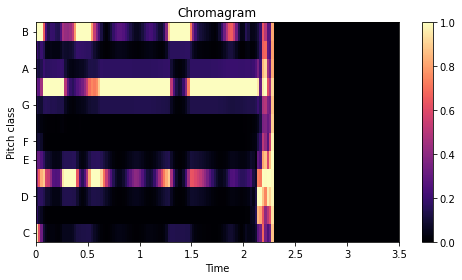

Time (s) Chord
0.0 Gm
0.6501587301587302 G#m
1.3003174603174603 G#m
1.9504761904761905 N
2.6006349206349206 N
3.250793650793651 N


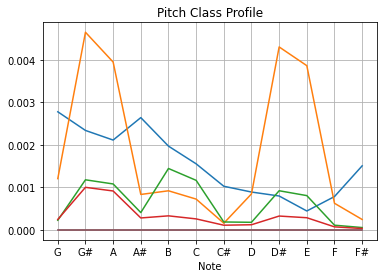

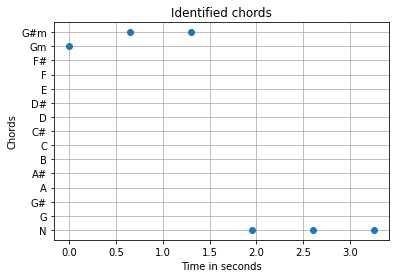

In [21]:
x = s[::4]
fs_re = int(fs/4)


#framing audio, window length = 8192, hop size = 1024 and computing PCP
nfft = 8192
hop_size = 1024
nFrames = int(np.round(len(x)/(nfft-hop_size)))
#zero padding to make signal length long enough to have nFrames
x = np.append(x, np.zeros(nfft))
xFrame = np.empty((nfft, nFrames))
start = 0   
chroma = np.empty((12,nFrames)) 
id_chord = np.zeros(nFrames, dtype='int32')
timestamp = np.zeros(nFrames)
max_cor = np.zeros(nFrames)


S = np.abs(librosa.stft(x, n_fft=1024))**2
chroma = librosa.feature.chroma_stft(S=S, sr=fs_re)
plt.figure(figsize=(7, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.xlim([0,3.5])
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()



print ('Time (s)', 'Chord')
for n in range(nFrames):
	xFrame[:,n] = x[start:start+nfft] 
	start = start + nfft - hop_size 
	timestamp[n] = n*(nfft-hop_size)/fs_re
	chroma[:,n] = compute_chroma(xFrame[:,n],fs_re)
	plt.figure(1)
	plt.plot(chroma[:,n])

	"""Correlate 12D chroma vector with each of 24 major and minor chords"""
	cor_vec = np.zeros(24)
	for ni in range(24):
		cor_vec[ni] = np.correlate(chroma[:,n], np.array(templates[ni])) 
	max_cor[n] = np.max(cor_vec)
	id_chord[n] =  np.argmax(cor_vec) + 1


#if max_cor[n] < threshold, then no chord is played
#might need to change threshold value
id_chord[np.where(max_cor < 0.3*np.max(max_cor))] = 0
for n in range(nFrames):
	print (timestamp[n],chords[id_chord[n]])


  
#Plotting all figures
plt.figure(1)
notes = ['G','G#','A','A#','B','C','C#','D','D#','E','F','F#']
plt.xticks(np.arange(12),notes)
plt.title('Pitch Class Profile')
plt.xlabel('Note')
plt.grid(True)

plt.figure(2)
plt.yticks(np.arange(25), chords)
plt.plot(timestamp, id_chord, linestyle='none', marker='o')
plt.xlabel('Time in seconds')
plt.ylabel('Chords')
plt.title('Identified chords')
plt.grid(True)
plt.show()